<a name="top" id="top"></a>

<div align="center">
    <h1>Sensor placement and fault diagnosis in water distribution netwroks</h1>
    <a href="https://github.com/anurag-r20">Anurag Ramesh</a>
    <br>
    <i>Graduate Research Assistant</i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i> Assistant Professor </i>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <br>
   <a href="https://colab.research.google.com/github.com/anurag-r20/WDN_Sensor_Placement/WDN_Sensor_Placement.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

## Sensor Placement in Water Distribution Networks (WDN)

In this notebook, we formulate an optimization problem to identify the optimal placement of pressure sensors in a Water Distribution Network (WDN). The WDN is represented on a constrained graph $G(V,E)$, where $V$ is the set of vertices and $E$ is the set of edges.

We consider four different formulations of the optimization problem, including Mixed Integer Programming (MIP), Mixed Integer Quadratic Programming (MIQP), and Quadratic Unconstrained Binary Optimization (QUBO). The optimization problem is solved using three different solvers: Gurobi, Simulated Annealing, and D-Wave's implementation of Quantum Annealing via **[neal](https://github.com/dwavesystems/dwave-neal)**.

Additionally, we leverage D-Wave's package **[dwavebinarycsp](https://github.com/dwavesystems/dwavebinarycsp)** to translate constraint satisfaction problems into QUBOs. For Groebner basis computations, we use **[Sympy](https://www.sympy.org/)** for symbolic computation in Python and **[Networkx](https://networkx.github.io/)** for network models and graphs.

In [144]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install dimod, neal, and pyomo
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal


# Let's setup the D-Wave connection
!pip install dwave-networkx
!pip install dwave-system



In [145]:
# Import the Pyomo library, which can be installed via pip, conda or from Github https://github.com/Pyomo/pyomo
import pyomo.environ as pyo
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import pandas as pd
import os
import time
import operator
from collections import OrderedDict
from collections import Counter
# Import networkx for graph problems
import networkx as nx
from matplotlib.lines import Line2D
# Import DWave
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint


In [146]:
def WDN_network_data(city, base_dir=None):

    """Fetches and processes Water Distribution Network (WDN) data for a given city.

    This function reads node, edge, and water consumption data from specified files
    for a given city and returns the data as dictionaries.

    Args:
        city (str): The name of the city to fetch data for. Should be one of 'Apulian', 
            'Fossolo', or 'Test'.
        base_dir (str, optional): The base directory where the data files are located. 
            Defaults to the directory of the script.

    Returns:
        tuple: A tuple containing three dictionaries:
            - nodes (dict): Dictionary of nodes with node names as keys and (x, y) 
              coordinates as values.
            - edges (dict): Dictionary of edges with tuples of node pairs as keys.
            - water_consumption (dict): Dictionary of water consumption with node names
              as keys and consumption values as values.

    Raises:
        FileNotFoundError: If any of the data files do not exist.
        ValueError: If the provided city name is not valid.

    Examples:
        >>> nodes, edges, water_consumption = WDN_network_data('Apulian')
        >>> print(nodes)
        {'J1': (10.0, 20.0), 'J2': (15.0, 25.0)}
    """

    # Set base directory
    if base_dir is None:
        base_dir = os.path.dirname(os.path.abspath(__file__))  # Set to script's directory
    
    data_dir = os.path.join(base_dir, 'Data/WDN_Data')
    city_files = {
        "Apulian": {
            "nodes": f"{data_dir}/Apulian_WDN/Apulian_WDN_Nodes.txt",
            "edges": f"{data_dir}/Apulian_WDN/Apulian_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Apulian_WDN/Apulian_WDN_Water_Consumption.txt"
        },
        "Fossolo": {
            "nodes": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Nodes.txt",
            "edges": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Edges.txt",
            "water_consumption": f"{data_dir}/Fossolo_WDN/Fossolo_WDN_Water_Consumption.txt"
        },
        "Test": {
            "nodes": f"{data_dir}/Test_WDN/Test_Nodes.txt",
            "edges": f"{data_dir}/Test_WDN/Test_Edges.txt",
            "water_consumption": f"{data_dir}/Test_WDN/Test_Water_Consumption.txt"
        }
        
    }

    # Check if the city is valid
    if city not in city_files:
        print(f"Error: Unknown city {city}.")
        return None, None, None

    # Get file paths
    nodes_file_path = city_files[city]["nodes"]
    edges_file_path = city_files[city]["edges"]
    water_consumption_file_path = city_files[city]["water_consumption"]

    # Print absolute file paths for debugging
    print(f"Nodes file path: {nodes_file_path}")
    print(f"Edges file path: {edges_file_path}")
    print(f"Water consumption file path: {water_consumption_file_path}")

    # Check if files exist
    for file_path in [nodes_file_path, edges_file_path, water_consumption_file_path]:
        if not os.path.exists(file_path):
            print(f"Error: The file {file_path} does not exist.")
            return None, None, None

    # Importing node data
    nodes_df = pd.read_csv(nodes_file_path, skiprows=1, names=["Node", "X", "Y"]) # nodes dataframe (exclude heading)
    nodes_df['Node'] = nodes_df['Node'].str.strip() # strip spaces
    nodes = {row['Node']: (float(row['X']), float(row['Y'])) for i, row in nodes_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.

    # Importing edge data
    edges_df = pd.read_csv(edges_file_path, skiprows=1, names=["Node1", "Node2"]) # edges dataframe
    edges_df['Node1'] = edges_df['Node1'].str.strip() # strip spaces
    edges_df['Node2'] = edges_df['Node2'].str.strip()
    edges = {((row['Node1']), (row['Node2'])) for i, row in edges_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.
    
    # Importing water consumption data
    water_consumption_df = pd.read_csv(water_consumption_file_path, skiprows=1, names=["Node", "Consumption"]) # water consumption dataframe
    water_consumption_df['Node'] = water_consumption_df['Node'].str.strip() # strip spaces
    water_consumption = {row['Node']: (float(row['Consumption'])) for i, row in water_consumption_df.iterrows()} # Convert the data to a dictionary with node names as keys and (x, y) tuples as values.

    return nodes, edges, water_consumption

In [147]:
base_dir = '/mnt/c/Users/rames102/Desktop/Qualifier_2024'  # relpace with correct directory in your system
city = "Test"
coords, edges, water_consumption = WDN_network_data(city, base_dir)

Nodes file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/Test_WDN/Test_Nodes.txt
Edges file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/Test_WDN/Test_Edges.txt
Water consumption file path: /mnt/c/Users/rames102/Desktop/Qualifier_2024/Data/WDN_Data/Test_WDN/Test_Water_Consumption.txt


In [148]:
def Construct_Graph(city):

    """Constructs a Water Distribution Network (WDN) graph for a given city.

    This function constructs a graph using the node coordinates and edges imported previously.
    It creates a NetworkX graph, adds nodes with their coordinates as attributes, and adds edges.

    Args:
        city (str): The name of the city for which to construct the graph. The function assumes
            that the node coordinates and edges for the specified city have been imported.

    Returns:
        nx.Graph: A NetworkX graph object representing the WDN. If the coordinates or edges are
            not available, returns None.

    Raises:
        ValueError: If the city name is not valid or if the necessary data is missing.

    Examples:
        >>> G = Construct_Graph('Apulian')
        >>> print(G.nodes(data=True))
        [('J1', {'pos': (10.0, 20.0)}), ('J2', {'pos': (15.0, 25.0)})]
    """

    if coords is None or edges is None:
        return None
    
    G = nx.Graph()

    # Defining Nodes in their coordinates
    for node, coord in coords.items():
        G.add_node(node, pos=coord)

    # Add edges
    G.add_edges_from(edges)
    
    return G

In [149]:
G = Construct_Graph(city)
print(G)

Graph with 5 nodes and 6 edges


In [150]:
def centrality(G, water_consumption):

    """Calculates centrality metrics for a given city's WDN graph and water consumption data.

    This function computes various centrality metrics for the provided NetworkX graph and calculates
    vertex costs based on water consumption data and centrality measures.

    Args:
        G (nx.Graph): A NetworkX graph representing the water distribution network (WDN) for the city.
        water_consumption (dict): A dictionary where keys are node names and values are the water consumption
            at each node.

    Returns:
        tuple: A tuple containing two elements:
            - vertex_cost (dict): Dictionary where keys are node names and values are the computed costs
              for each vertex based on normalized demand and degree centrality.
            - edge_betweenness (dict): Dictionary of edge betweenness centrality values, where keys are
              tuples representing edges and values are the betweenness centrality scores for those edges.

    Raises:
        KeyError: If a node from the graph is not found in the water consumption data.

    Examples:
        >>> vertex_cost, edge_betweenness = centrality(G, water_consumption)
        >>> print(vertex_cost)
        {'J1': 2.5, 'J2': 3.0}
        >>> print(edge_betweenness)
        {(J1, J2): 0.1, (J2, J3): 0.2}
    """
    
    # Calculating edge betweenness centrality
    edge_betweenness = nx.edge_betweenness_centrality(G)

    # Calculate degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Edge betweenness centrality as weights
    for (u, v, d) in G.edges(data=True):
        d['weight'] = edge_betweenness[(u, v)]

    # Define the weights C and D (Need to identify the right values)
    C = 1.0
    D = 1.0

    def compute_normalized_demand(water_consumption):        
        max_demand = max(water_consumption.items(), key=operator.itemgetter(1))[1]
        return {node: val / max_demand for node, val in water_consumption.items()}

    normalized_demand = compute_normalized_demand(water_consumption)

    # Debugging: print the node names in the graph
    print("Graph nodes:", list(G.nodes()))
    
    # Debugging: print the keys in normalized_demand
    print("Normalized demand keys:", list(normalized_demand.keys()))

    # Vertex cost function:
    vertex_cost = {}
    for node in G.nodes():
        f_i = 1 - normalized_demand.get(node, None)   # function of the water need at each node i
        if f_i is None:
            print(f"Node {node} not found in normalized_demand")
            continue
        g_i = degree_centrality[node]  # node weights
        vertex_cost[node] = C * f_i + D * g_i
    
    return vertex_cost, edge_betweenness


In [151]:
VC, EB = centrality(G, water_consumption)
print(VC)
print(EB)

Graph nodes: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5']
Normalized demand keys: ['J-1', 'J-2', 'J-3', 'J-4', 'J-5']
{'J-1': 1.407180819249107, 'J-2': 0.75, 'J-3': 1.3722849770152263, 'J-4': 1.6235410222670335, 'J-5': 1.4134183228805304}
{('J-1', 'J-4'): 0.23333333333333336, ('J-1', 'J-2'): 0.2333333333333333, ('J-2', 'J-5'): 0.2333333333333333, ('J-2', 'J-3'): 0.2333333333333333, ('J-3', 'J-4'): 0.2333333333333333, ('J-4', 'J-5'): 0.2333333333333333}


In [152]:
def plot_WDN(G):

    """Plots the graph of the city's Water Distribution Network (WDN).

    This function visualizes the WDN graph using NetworkX and Matplotlib. It plots nodes with their
    positions, edges, and labels for both nodes and edges. It also includes a legend and title for the plot.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.

    Returns:
        None

    Raises:
        ValueError: If the graph `G` is None or the position dictionary is empty.

    Examples:
        >>> plot_WDN(G)
    """

    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    pos = nx.get_node_attributes(G, 'pos')
    
    if not pos:
        print("Error: Position dictionary is empty.")
        return

    print("Position Dictionary:", pos)

    # Create plot
    plt.figure(figsize=(16, 8))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
    nx.draw_networkx_edges(G, pos, edge_color='gray')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='Potential nodes for sensor placement')
    plt.legend(handles=[blue_patch], loc='best')

    plt.title(f"Water Distribution Network - {city}")
    plt.show()

Position Dictionary: {'J-1': (1597.24, 1180.0), 'J-2': (1432.13, 1340.0), 'J-3': (745.9, 1346.0), 'J-4': (921.33, 1124.0), 'J-5': (1344.42, 1015.0)}


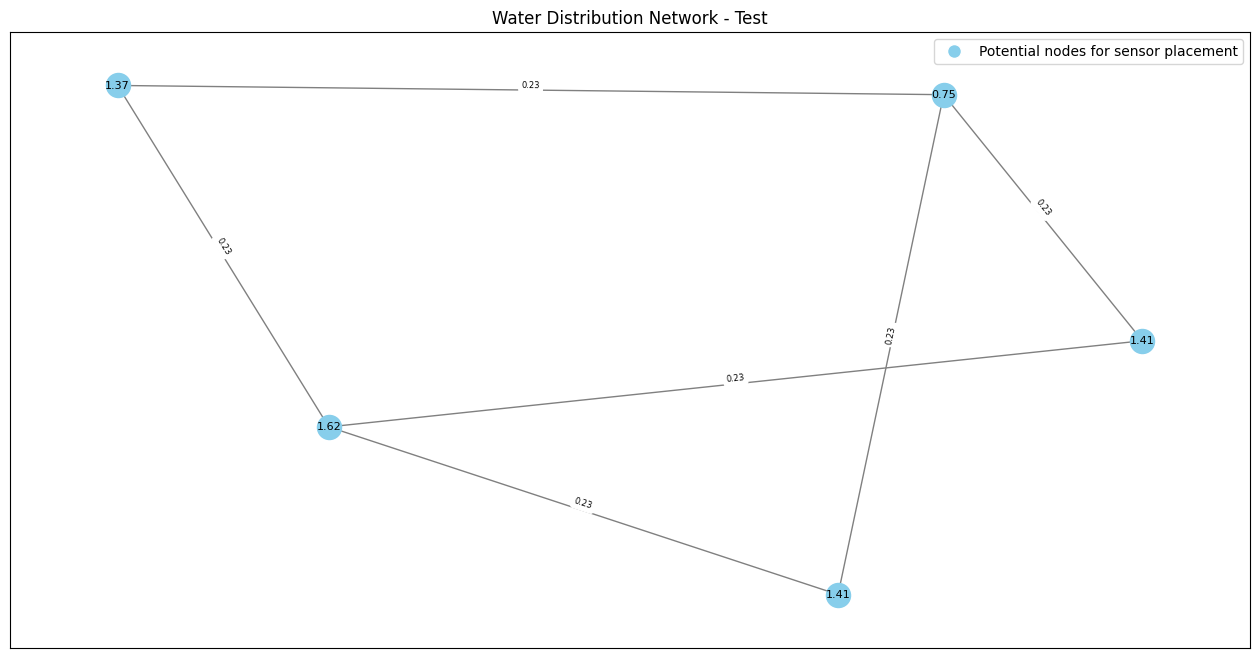

In [153]:
plot_WDN(G)

The solution to this graph problem is explored using different reformulations of the problem.

First, we formulate the graph optimization problem as a Mixed Integer Program (MIP) (Speziali et al. (2021)):


$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$

Here, $c_{i}$ represents the cost of the $i^{th}$ node, $w_{ij}$ represents the weight corresponding to the edge between nodes $i$ and $j$, and $x_{i} \in \{0, 1\}^{n}$ is a binary decision variable that indicates whether a sensor is placed at the $i^{th}$ node. $s$ is the predefined total number of sensors.

Next, the Quadratic Unconstrained Binary Optimzation (QUBO) formulation of the graph problem is explored. Consider the MIP model from before:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j}) \\
    \textrm{s.t.} & \sum_{i \in V} x_{i} = s \\
    & x_{i} \in \{0,1 \}^{n}
\end{array}
$$
To implement the problem as a QUBO, the constraint should be lifted up into the objective function such that the problem becomes unconstrained. This is performed as follows:
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} (w_{ij}(1 - x_{j} - x_{i} + x_{i}x_{j})) + \rho(\sum_{i \in V} x_{i} - s)^2 \\
\end{array}
$$
where $\rho$ is a scalar penalty term. Further simplification leads to
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i} + \sum_{(i, j) \in E} w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j} - \sum_{(i, j) \in E} w_{ij}x_{i} + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}s + \rho s^2 \\
\end{array}
$$
Since, $x_{i}$ is a binary variable, we can write $x_{i}$ as $x_{i}^2$. Taking this into account, the problem now becomes: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} & \sum_{i \in V} c_{i}x_{i}^2 + \sum_{(i, j) \in E}w_{ij} - \sum_{(i, j) \in E} w_{ij}x_{j}^2 - \sum_{(i, j) \in E} w_{ij}x_{i}^2 + \sum_{(i, j) \in E} w_{ij}x_{i}x_{j} + \rho\sum_{i \in V} x_{i}^2 - 2\rho\sum_{i \in V} x_{i}^2s + \rho s^2 \\
\end{array}
$$
Performing some algebraic manipulations, we have our QUBO problem.
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined.

In [154]:
def create_pyomo_model(G):  # Adding problem_type as a parameter

    """Initializes a Pyomo model for optimizing sensor placement in a city's Water Distribution Network (WDN).

    This function sets up a Pyomo model with nodes, edges, and associated parameters such as demand,
    vertex cost, and edge betweenness. It also defines the binary decision variables for sensor placement.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.

    Returns:
        pyo.ConcreteModel: A Pyomo ConcreteModel instance with sets, parameters, and decision variables defined.

    Raises:
        ValueError: If the graph `G` is None.

    Examples:
        >>> model = create_pyomo_model(G)
        >>> print(model)
    """

    if G is None:
        print(f"{city} does not exist.")
        return None

    # Create a pyomo model
    model = pyo.ConcreteModel()

    # Define pyomo sets for graph G
    nodes = list(G.nodes())
    edges = list(G.edges())
    model.nodes = pyo.Set(initialize=nodes)
    model.edges = pyo.Set(initialize=edges, dimen=2)

    # Parameters
    demand = water_consumption
    model.demand = pyo.Param(model.nodes, initialize=demand, mutable=True)
    model.c = pyo.Param(model.nodes, initialize=VC, mutable=True)  # vertex cost
    model.w = pyo.Param(model.edges, initialize=EB, mutable=True)  # edge_betweenness for edge weights

    # Binary decision variable
    model.x = pyo.Var(model.nodes, within=pyo.Binary)

    return model

In [155]:
model = create_pyomo_model(G)

In [156]:
# Mixed Integer Program model (MIP)
    
def MIQP(G, model, s):

    """Generates a Mixed Integer Programming (MIP) model for the given sensor placement problem.

    This function defines the objective function and constraints for the MIP model, aiming to optimize
    sensor placement in the city's Water Distribution Network (WDN). The objective function minimizes
    the total cost based on vertex costs and edge betweenness, while the constraint ensures that exactly
    `s` sensors are placed.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
        model (pyo.ConcreteModel): A Pyomo ConcreteModel instance with sets and parameters defined.
        s (int): The number of sensors to be placed in the network.

    Returns:
        pyo.ConcreteModel: The updated Pyomo model with the objective function and constraints added.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> model = MIQP(G, model, 5)
        >>> print(model.obj)
    """

    if model is None:
        return None
    
    # Define objective function
    def objective_rule_MIQP(model):
        return sum(model.c[i] * model.x[i] for i in model.nodes) + \
                sum(model.w[(i, j)] * (1 - model.x[i] - model.x[j] + model.x[i] * model.x[j]) for (i, j) in model.edges)

    model.obj = pyo.Objective(rule=objective_rule_MIQP, sense=pyo.minimize)

    # Constraints
    def sensor_constraint_rule_MIQP(model):
        return sum(model.x[i] for i in model.nodes) == s

    model.sensor_constraint_MIQP = pyo.Constraint(rule=sensor_constraint_rule_MIQP)

    return model

In [157]:
# Quadratic Unconstrained Binary Optimization model (QUBO)

def QUBO(G, model, s, rho):

    """Generates a Quadratic Unconstrained Binary Optimization (QUBO) model for the given problem.

    This function defines the objective function for the QUBO model, which aims to optimize sensor placement
    in the city's Water Distribution Network (WDN). The objective function includes terms for vertex costs,
    edge interactions, and a penalty for deviating from the specified number of sensors.

    Args:
        G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
        model (pyo.ConcreteModel): A Pyomo ConcreteModel instance with sets and parameters defined.
        s (int): The number of sensors to be placed in the network.
        rho (float): Penalty parameter for the constraint that exactly `s` sensors must be placed.

    Returns:
        pyo.ConcreteModel: The updated Pyomo model with the QUBO objective function added.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> model = QUBO(G, model, 5, 0.1)
        >>> print(model.obj)
    """

    if model is None:
        return None

    # # Removing previous objective function definition:
    # if hasattr(model, 'obj'):
    #     model.del_component(model.obj)
    # model.obj = pyo.Objective(rule=objective_rule_MIQP, sense=pyo.minimize)

    # # Removing previous constraint definition:
    # if hasattr(model, 'sensor_constraint'):
    #     model.del_component(model.sensor_constraint_MIQP)
    # model.sensor_constraint_MIQP = pyo.Constraint(rule=sensor_constraint_rule_MIQP)


    # Define objective function 
    def objective_rule_QUBO(model):
        term1 = sum(model.c[i] * model.x[i] for i in model.nodes)
        term2 = sum(model.w[(i, j)] * (1 - model.x[i]) * (1 - model.x[j]) for (i, j) in model.edges)
        term3 = rho * (sum(model.x[i] for i in model.nodes) - s) ** 2
        return term1 + term2 + term3

    model.obj = pyo.Objective(rule=objective_rule_QUBO, sense=pyo.minimize)

    return model

    # No constraints for QUBO

In [158]:
# # Coverage plot

# solver = pyo.SolverFactory('gurobi', solver_io='python')
# objective_value_list_MIQP = []
# objective_value_list_QUBO = []

# def coverage(G, s, rho):
    # """Computes and plots coverage metrics for the Water Distribution Network (WDN) using both MIP and QUBO formulations.

    # This function iteratively solves the MIP and QUBO models for different numbers of sensors and records
    # the objective values. It uses the Gurobi solver to find the optimal solutions and appends the results
    # to lists for comparison.

    # Args:
    #     G (nx.Graph): A NetworkX graph object representing the water distribution network (WDN) for the city.
    #     s (int): The maximum number of sensors to be placed.
    #     rho (float): Penalty parameter for the QUBO model.

    # Returns:
    #     tuple: A tuple containing two lists:
    #         - objective_value_list_MIQP (list): A list of objective values obtained from the MIP formulation.
    #         - objective_value_list_QUBO (list): A list of objective values obtained from the QUBO formulation.

    # Raises:
    #     ValueError: If the solver or model is not properly defined.

    # Examples:
    #     >>> objective_value_list_MIQP, objective_value_list_QUBO = coverage(G, 5, 0.1)
    #     >>> print(objective_value_list_MIQP)
    #     [100, 95, 90]
    #     >>> print(objective_value_list_QUBO)
    #     [102, 96, 89]
    # """

#     # MIP
#     for s in range(0, len(G.nodes())+1):
#         model_MIQP = MIQP(G, model, s)
#         # Solve MIQP and append data to list for each iteration
#         results_MIQP = solver.solve(model_MIQP, tee=True) # MIP formulation result
#         objective_value_MIQP = pyo.value(model_MIQP.obj)
#         print("Objective value from MIQP formulation: \n", objective_value_MIQP)
#         print("\n")
#         objective_value_list_MIQP.append(objective_value_MIQP)

#     # QUBO
#     for s in range(0, len(G.nodes())+1):
#         model_QUBO = QUBO(G, model, s, rho)
#         # Solve QUBO and append data to list for each iteration
#         results_QUBO = solver.solve(model_QUBO, tee=True) # MIP formulation result
#         objective_value_QUBO = pyo.value(model_QUBO.obj)
#         print("Objective value from QUBO formulation: \n", objective_value_QUBO)
#         print("\n")
#         objective_value_list_QUBO.append(objective_value_QUBO)

#     return objective_value_list_MIQP, objective_value_list_QUBO

In [159]:
# def plot_coverage(s, objective_value_list_MIQP, objective_value_list_QUBO):

    # """Plots coverage metrics for MIQP and QUBO formulations.

    # This function generates a side-by-side plot comparing the coverage objective values from MIQP and QUBO models
    # for different numbers of sensors. It visualizes the performance of each method across a range of sensor counts.

    # Args:
    #     s (list): A list of sensor counts used in the coverage calculations.
    #     objective_value_list_MIQP (list): A list of objective values from the MIQP formulation.
    #     objective_value_list_QUBO (list): A list of objective values from the QUBO formulation.

    # Returns:
    #     None

    # Examples:
    #     >>> plot_coverage(range(1, 6), [100, 95, 90, 85, 80], [102, 96, 89, 84, 78])
    # """

#     # Create a figure with two subplots side by side
#     fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
#     # Plot the MIQP coverage on the first subplot
#     axs[0].plot(s, objective_value_list_MIQP, label='MIQP', color='blue')
#     axs[0].set_xlabel('Number of Sensors')
#     axs[0].set_ylabel('Coverage Objective Value')
#     #axs[0].set_title('MIQP')
#     axs[0].set_xticks(range(min(s), max(s) + 1))
#     axs[0].legend()
    
#     # Plot the QUBO coverage on the second subplot
#     axs[1].plot(s, objective_value_list_QUBO, label='QUBO', color='red')
#     axs[1].set_xlabel('Number of Sensors')
#     axs[1].set_ylabel('Coverage Objective Value')
#     #axs[1].set_title('QUBO')
#     axs[1].set_xticks(range(min(s), max(s) + 1))
#     axs[1].legend()

#     # Display the plots
#     plt.show()

In [160]:
# s = list(range(0, len(G.nodes())+1)) # List of feasible number of sensors that can be placed in the WDN
# rho = np.sum(np.abs(list(VC.values()))) + 1 # Constant for penalty term for QUBO
# objective_value_list_MIQP, objective_value_list_QUBO = coverage(G, s, rho)
# plot_coverage(s, objective_value_list_MIQP, objective_value_list_QUBO)

In [161]:
s = 3
rho = np.sum(np.abs(list(VC.values()))) + 1 # Constant for penalty term for QUBO
model_MIQP = MIQP(G, model, s)
model_QUBO = QUBO(G, model, s, rho)

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


In [162]:
# Solve
solver = pyo.SolverFactory('gurobi', solver_io='python')
results_MIQP = solver.solve(model_MIQP, tee=True) # MIP formulation result

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x43495606
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+01]
  QObjective range [2e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Found heuristic solution: objective 3.7627991
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -1.147464e+01, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

In [163]:
results_QUBO = solver.solve(model_QUBO, tee=True) # QUBO formulation result

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1 rows, 5 columns and 5 nonzeros
Model fingerprint: 0x43495606
Model has 15 quadratic objective terms
Variable types: 0 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+01, 5e+01]
  QObjective range [2e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Found heuristic solution: objective 3.7627991
Presolve time: 0.00s
Presolved: 11 rows, 15 columns, 35 nonzeros
Variable types: 0 continuous, 15 integer (15 binary)

Root relaxation: objective -1.147464e+01, 8 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap |

In [164]:
def sensor_placement_results(model_MIQP, model_QUBO):

    """Prints and returns sensor placement results for MIP and QUBO models.

    This function displays the sensor placement status for each node in both MIP and QUBO models. It provides
    a clear view of which nodes have sensors placed according to each optimization approach. It also returns
    dictionaries with sensor placement information for further analysis.

    Args:
        model_MIQP (pyo.ConcreteModel): The Pyomo model with MIP formulation, including sensor placement variables.
        model_QUBO (pyo.ConcreteModel): The Pyomo model with QUBO formulation, including sensor placement variables.

    Returns:
        tuple: A tuple containing two dictionaries:
            - sensor_placement_MIQP (dict): Dictionary with node names as keys and binary values (0 or 1) indicating
              whether a sensor is placed at each node according to the MIP model.
            - sensor_placement_QUBO (dict): Dictionary with node names as keys and binary values (0 or 1) indicating
              whether a sensor is placed at each node according to the QUBO model.

    Examples:
        >>> sensor_placement_MIQP, sensor_placement_QUBO = sensor_placement_results(model_MIQP, model_QUBO)
        >>> print(sensor_placement_MIQP)
        {'J1': 1, 'J2': 0, 'J3': 1}
        >>> print(sensor_placement_QUBO)
        {'J1': 1, 'J2': 1, 'J3': 0}
    """

    # Print results for MIP
    print("MIP results")
    for node in model_MIQP.nodes:
        print(f"Node {node}: Sensor placed = {pyo.value(model_MIQP.x[node])}")

    sensor_placement_MIQP = {node: pyo.value(model_MIQP.x[node]) for node in model_MIQP.nodes}

    # Print results for QUBO
    print("\nQUBO results")
    for node in model_QUBO.nodes:
        print(f"Node {node}: Sensor placed = {pyo.value(model_QUBO.x[node])}")

    sensor_placement_QUBO = {node: pyo.value(model_QUBO.x[node]) for node in model_QUBO.nodes}

    return sensor_placement_MIQP, sensor_placement_QUBO


In [165]:
sensor_placement_MIQP, sensor_placement_QUBO = sensor_placement_results(model_MIQP, model_QUBO)

MIP results
Node J-1: Sensor placed = 0.0
Node J-2: Sensor placed = 1.0
Node J-3: Sensor placed = 1.0
Node J-4: Sensor placed = 1.0
Node J-5: Sensor placed = 0.0

QUBO results
Node J-1: Sensor placed = 0.0
Node J-2: Sensor placed = 1.0
Node J-3: Sensor placed = 1.0
Node J-4: Sensor placed = 1.0
Node J-5: Sensor placed = 0.0


In [166]:
def save_plot(directory, filename, format='png'):
    
    """Saves a Matplotlib plot to a specified directory with the given filename and format.

    This function ensures that the directory exists, constructs the full file path, and saves the plot
    using Matplotlib. It supports various formats, with 'png' as the default.

    Args:
        directory (str): The directory where the plot will be saved.
        filename (str): The name of the file (without extension) to save the plot as.
        format (str): The format of the saved plot (default is 'png').

    Returns:
        str: The full path to the saved plot.

    Examples:
        >>> filepath = save_plot('/plots', 'my_plot', 'pdf')
        >>> print(filepath)
        '/plots/my_plot.pdf'
    """

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Construct the full file path
    filepath = os.path.join(directory, f"{filename}.{format}")
    
    # Save the plot
    plt.savefig(filepath, format=format)
    plt.close()
    
    return filepath

In [167]:
def plot_sensor_placement(city, sensor_placement, subplot_index, title):

    """Plots a city's Water Distribution Network (WDN) and the optimal sensor placement.

    This function visualizes the WDN graph with nodes colored based on sensor placement: red for nodes with
    sensors and sky blue for nodes without. It uses Matplotlib to create the plot and adds a legend to distinguish
    between sensor and non-sensor nodes.

    Args:
        city (str): The name of the city for which the WDN is plotted.
        sensor_placement (dict): A dictionary indicating sensor placement at each node (1 for sensor, 0 for no sensor).
        subplot_index (int): The index of the subplot where the WDN will be plotted (1 or 2).
        title (str): The title of the plot.

    Returns:
        None

    Raises:
        ValueError: If the graph `G` is None.

    Examples:
        >>> plot_sensor_placement('Apulian', {'J1': 1, 'J2': 0, 'J3': 1}, 1, 'Optimal Sensor Placement')
    """

    if G is None:
        print(f"Graph could not be constructed for {city}.")
        return

    pos = nx.get_node_attributes(G, 'pos')

    # Create plot
    plt.subplot(2, 1, subplot_index)
    
    # Determine node colors based on sensor placement
    node_colors = ['red' if sensor_placement.get(node, 0) == 1 else 'skyblue' for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    #nx.draw_networkx_labels(G, pos, font_size=6, font_color='black')

    # Round off edge and node labels to two decimals for the plot
    edge_labels_rounded = {k: round(v, 2) for k, v in EB.items()}
    node_labels_rounded = {k: round(v, 2) for k, v in VC.items()}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_rounded, label_pos=0.5, font_size=6, verticalalignment='bottom')
    nx.draw_networkx_labels(G, pos, labels=node_labels_rounded, font_size=8, font_color='black')

    # Add legend
    red_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Sensor placed')
    blue_patch = Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=10, label='No sensor')
    plt.legend(handles=[red_patch, blue_patch], loc='best')

    plt.title(title)

In [168]:
def plot_comparison(city, sensor_placement_MIQP, sensor_placement_QUBO):

    """Plots a city's Water Distribution Network (WDN) with optimal sensor placements from both MIP and QUBO formulations.

    This function generates a single figure with two subplots, showing the WDN with sensor placements obtained
    through the MIP and QUBO models. It utilizes the `plot_sensor_placement` function to visualize the results.

    Args:
        city (str): The name of the city for which the WDN is plotted.
        sensor_placement_MIQP (dict): A dictionary indicating sensor placement at each node from the MIP formulation.
        sensor_placement_QUBO (dict): A dictionary indicating sensor placement at each node from the QUBO formulation.

    Returns:
        None

    Examples:
        >>> plot_comparison('Apulian', {'J1': 1, 'J2': 0, 'J3': 1}, {'J1': 0, 'J2': 1, 'J3': 1})
    """

    plt.figure(figsize=(16, 16))

    plot_sensor_placement(city, sensor_placement_MIQP, 1, 'Sensor Placement - Solution obtained through MIP formulation')
    plot_sensor_placement(city, sensor_placement_QUBO, 2, 'Sensor Placement - Solution obtained through QUBO formulation')

    plt.show()

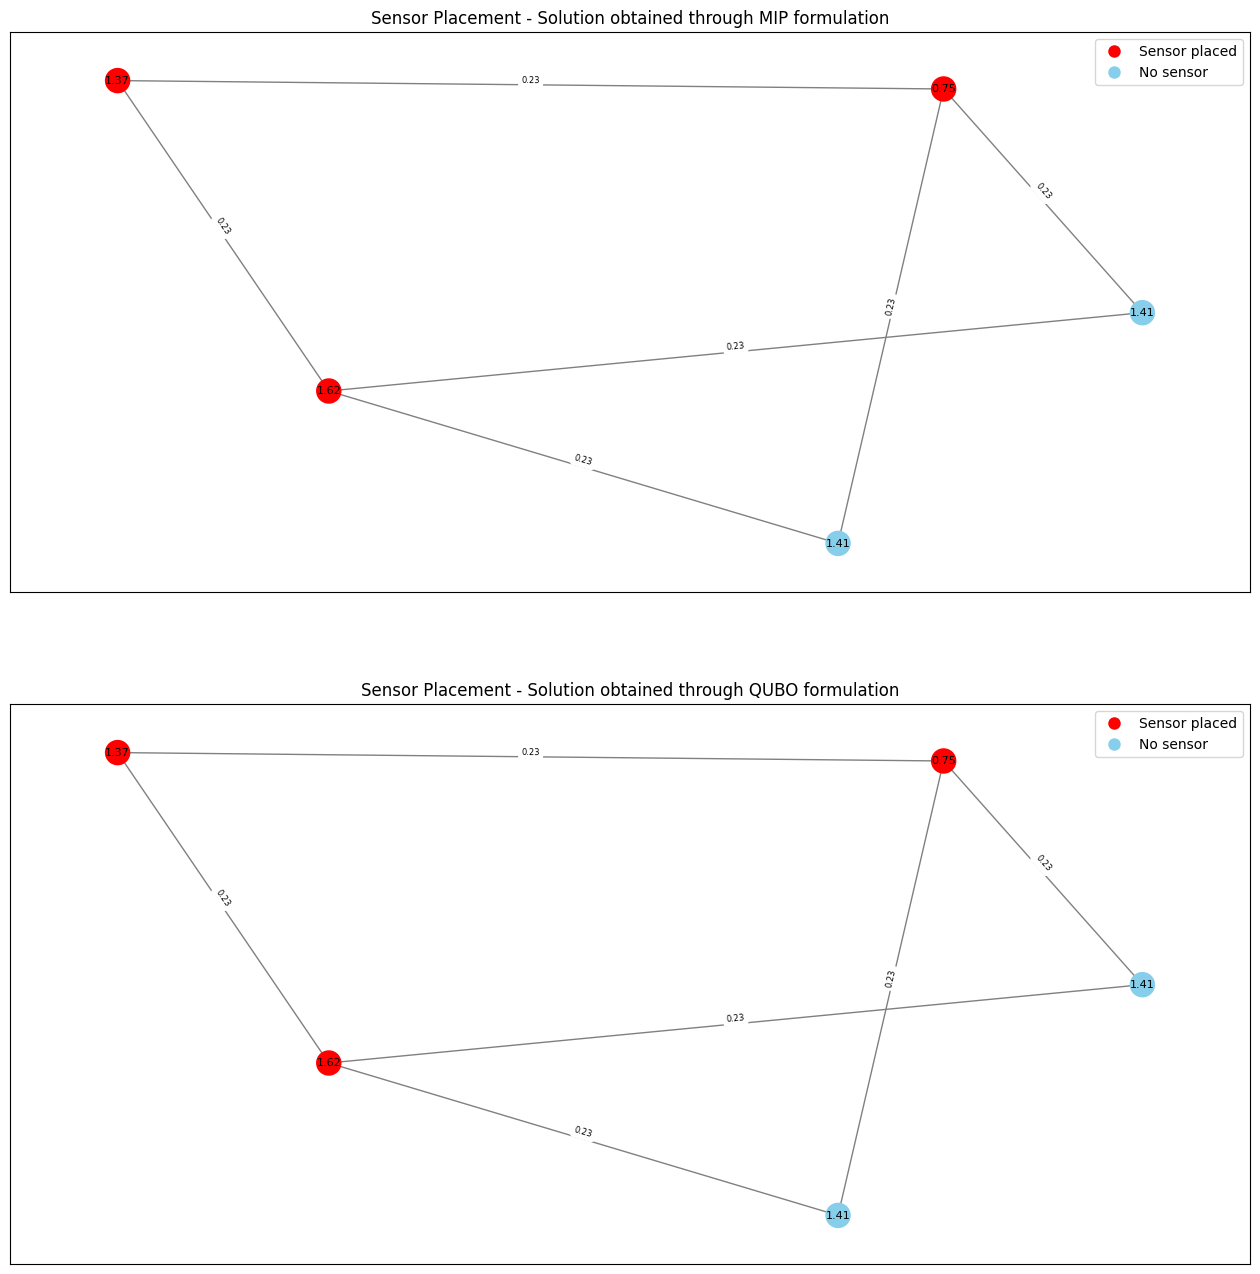

In [169]:
plot_comparison(city, sensor_placement_MIQP, sensor_placement_QUBO)

In [170]:
# Save the plot
directory = '/mnt/c/Users/rames102/Desktop/Qualifier_2024/Images'
filename = f"{city}_WDN_Optimal_{s}_sensors"
save_plot(directory, filename)
print(f"Plot saved to {os.path.abspath(os.path.join(directory, filename))}.png")

Plot saved to /mnt/c/Users/rames102/Desktop/Qualifier_2024/Images/Test_WDN_Optimal_3_sensors.png


## Simulated Annealing:
First, we build the adjacency matrix $Q$ that is obtained from the QUBO model. Remember that the QUBO problem is formulated as follows: 
$$
\begin{array}{rl}
    \displaystyle%
    \min_{x} \left( \sum_{i \in V} (c_i + \rho - 2\rho s - w_{ij})x_i^2 + \sum_{(i,j) \in E} w_{ij}x_i x_j + \rho s^2 + \sum_{(i,j) \in E}{w_{ij}} \right) \\
\end{array}
$$
where $s$ is the total number of sensors that is predefined. And, We know that in general, a QUBO problem is defined as: 
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E} Q_{ij}x_i x_j + \sum_{i \in V}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.


Comparing the above problems, it is evident that 
$$
\begin{array}{rl}
    \displaystyle%
    Q_{ii} = (c_{i} + \rho -2\rho s) - \sum_{j \in V}w_{ij} \\
    
    Q_{ij} = w_{ij} \\ \\

    c_{Q} = \rho s^2 + \sum_{(i,j) \in E}{w_{ij}}
\end{array}
$$\

In [171]:
def build_Q_matrix(G, model, s):

    """Builds the Q matrix for the Quadratic Unconstrained Binary Optimization (QUBO) problem based on the given graph and model.

    This function constructs the Q adjacency matrix used in QUBO formulations, incorporating vertex costs, edge weights (edge betweenness), and constraints.

    Args:
        G (nx.Graph): The NetworkX graph object representing the water distribution network (WDN).
        model (pyo.ConcreteModel): The Pyomo model with the necessary parameters for QUBO.
        s (int): The number of sensors to be placed.

    Returns:
        tuple: A tuple containing:
            - Q (np.ndarray): The Q matrix for the QUBO problem.
            - cQ (float): The constant term in the QUBO objective function.

    Raises:
        ValueError: If the model is None.

    Examples:
        >>> Q, cQ = build_Q_matrix(G, model, 5)
        >>> print(Q)
        [[ 1.2 -0.5  0. ]
         [-0.5  1.5 -0.3]
         [ 0.  -0.3  1.1]]
        >>> print(cQ)
        2.5
    """
    
    G = Construct_Graph(city)

    # model = create_pyomo_model(city)

    if model is None:
        return None
    
    num_nodes = len(G.nodes()) # stores the number of nodes in the graph G
    nodes = list(G.nodes())

    # Correctly create node_costs using node names
    vertex_cost = np.array([VC[node] for node in nodes])
    weight = EB

    # Initialize the constraint matrix A and vector b
    A = np.ones((1, num_nodes))
    b = np.array([s])
    
    # Calculate rho
    rho = np.sum(np.abs(vertex_cost)) + 1
    
    # Construct Q matrix
    Q = rho * np.matmul(A.T, A)
    
    # Add node costs to the diagonal
    Q += np.diag(vertex_cost)
    
    # Adjust diagonal with constraints
    Q -= rho * 2 * np.diag(np.matmul(b.T, A))
    
    # Add edge weights to the Q matrix
    for (i, j), w in weight.items():
        Q[nodes.index(i), nodes.index(j)] += w
        Q[nodes.index(j), nodes.index(i)] += w  # Ensure symmetry as the Q adjacency matrix is square symmetric
    
    # Calculate constant term cQ
    cQ = rho * np.matmul(b.T, b)
    
    return Q, cQ


In [172]:
s = 3
Q, cQ = build_Q_matrix(G, model, s)
print("Q matrix:\n", Q , "\n")
print("cQ value:\n", cQ)

Q matrix:
 [[-36.42494489   7.79975847   7.56642514   7.79975847   7.56642514]
 [  7.79975847 -37.08212571   7.79975847   7.56642514   7.79975847]
 [  7.56642514   7.79975847 -36.45984073   7.79975847   7.56642514]
 [  7.79975847   7.56642514   7.79975847 -36.20858468   7.79975847]
 [  7.56642514   7.79975847   7.56642514   7.79975847 -36.41870738]] 

cQ value:
 68.09782627270707


In [173]:
## Not working ### (Why?)


# def compute_Q_matrix(city, rho, s):

#     "This function computes the Q adjacency matrix for the QUBO problem defined above"
    
#     G = Construct_Graph(city)

#     if G is None:
#         print(f"{city} does not exist.")
#         return None

#     water_consumption = WDN_network_water_consumption(city)

#     VC, EB = centrality(G, water_consumption)

#     model = create_model(city)

#     if model is None:
#         return None

#     num_nodes = len(G.nodes())
#     Q = np.zeros((num_nodes, num_nodes))
        
#     # Get node index mapping
#     node_index = {node: idx for idx, node in enumerate(G.nodes())}

#     # Sum of weights
#     sum_weights = {}
#     for node1, node2 in EB.keys():
#         if node1 not in sum_weights:
#             sum_weights[node1] = 0
#         if node2 not in sum_weights:
#             sum_weights[node2] = 0

#     # Iterate through the edge weights and sum weights for each node in node1
#     for (node1, node2), weight in EB.items():
#         sum_weights[node1] += weight

#     sum_weights = dict(OrderedDict(sorted(sum_weights.items(), key=lambda x: (x[0][0], int(x[0].split('-')[1])))))

#     # Fill in the diagonal terms
#     for node, idx in node_index.items():    
#         Q[idx, idx] = VC[node] + rho - 2 * rho * s - sum_weights[node]

#     # Fill in the off-diagonal terms
#     for (u, v), weight in EB.items():
#         idx = node_index[u]
#         idy = node_index[v]
#         Q[idx, idy] = weight/2
#         Q[idy, idx] = weight/2

#     # Calculating offset
#     beta = rho * (s ** 2) + sum(weight for (u, v), weight in EB.items())

#     return Q, beta


In [174]:
# city = "Apulian"

# G = Construct_Graph(city)

# if G is None:
#     print(f"{city} does not exist.")

# water_consumption = WDN_network_water_consumption(city)

# VC, EB = centrality(G, water_consumption)

# node_index = {node: idx for idx, node in enumerate(G.nodes())}


# print("\n")
# print(G.nodes(), "\n")
# print(node_index, "\n")
# print(VC, "\n")
# print(EB)

# sum_weights = {}
# for node1, node2 in EB.keys():
#     if node1 not in sum_weights:
#         sum_weights[node1] = 0
#     if node2 not in sum_weights:
#         sum_weights[node2] = 0

# # Iterate through the edge weights and sum weights for each node in node1
# for (node1, node2), weight in EB.items():
#     sum_weights[node1] += weight

# sum_weights = dict(OrderedDict(sorted(sum_weights.items(), key=lambda x: (x[0][0], int(x[0].split('-')[1])))))

# # Print the ordered dictionary
# print(sum_weights)


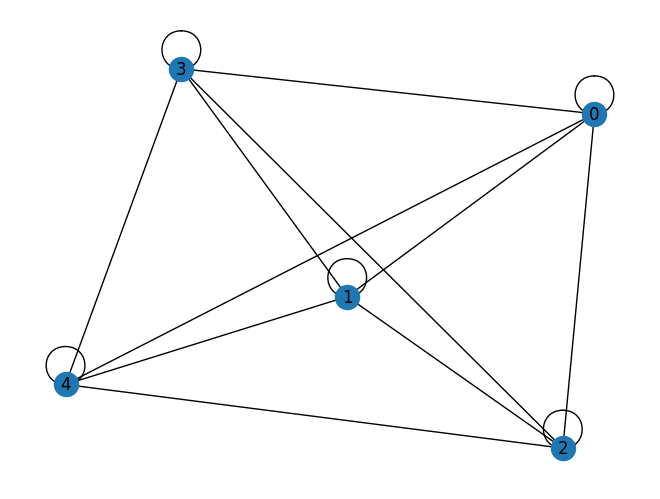

In [175]:
G = nx.from_numpy_matrix(Q)
nx.draw(G, with_labels=True)

In [176]:
# Binary Quadratic model (BQM)

def QUBO_dimod(Q, beta):

    """Creates a Binary Quadratic Model (BQM) from a Q matrix and an offset.

    This function constructs a BQM, which is used for solving quadratic optimization problems using binary variables.
    It uses the `dimod` library to create the model from the Q adjacency matrix and an offset value, preparing it for use with
    optimization solvers.

    Args:
        Q (np.ndarray): The Q matrix representing the quadratic terms in the optimization problem.
        beta (float): The offset value for the BQM.

    Returns:
        dimod.BinaryQuadraticModel: The Binary Quadratic Model constructed from the Q matrix and offset.

    Examples:
        >>> Q = np.array([[1, -1], [-1, 2]])
        >>> beta = 0.5
        >>> bqm = QUBO_dimod(Q, beta)
        >>> print(bqm)
        BinaryQuadraticModel({0: 1, 1: -1}, {(0, 1): -1}, 0.5, dimod.BINARY)
    """

    # Binary Quadratic Model
    bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset = beta) 
    
    return bqm

In [177]:
bqm = QUBO_dimod(Q, cQ) # returns bqm value
print(bqm)

# Use ExactSolver to sample the BQM
exactSampler = dimod.reference.samplers.ExactSolver()
exactSamples = exactSampler.sample(bqm)

# Print the sample results
print("Exact Solver Samples:")
print(exactSamples)

# If you want to extract and process the samples:
for sample, energy in exactSamples.data(['sample', 'energy']):
    print(sample, "Energy:", energy)

BinaryQuadraticModel({0: -36.424944887810376, 1: -37.08212570705948, 2: -36.459840730044256, 3: -36.20858468479245, 4: -36.41870738417895}, {(1, 0): 15.59951694949046, (2, 0): 15.132850282823794, (2, 1): 15.59951694949046, (3, 0): 15.59951694949046, (3, 1): 15.132850282823794, (3, 2): 15.59951694949046, (4, 0): 15.132850282823794, (4, 1): 15.59951694949046, (4, 2): 15.132850282823794, (4, 3): 15.59951694949046}, 68.09782627270707, 'BINARY')
Exact Solver Samples:
    0  1  2  3  4    energy num_oc.
25  1  0  1  0  1  4.192884       1
5   1  1  1  0  0  4.462799       1
27  0  1  1  0  1  4.469037       1
29  1  1  0  0  1  4.503932       1
11  0  1  1  1  0  4.679159       1
13  1  1  0  1  0  4.714055       1
19  0  1  0  1  1  4.720293       1
9   1  0  1  1  0   5.33634       1
23  0  0  1  1  1  5.342578       1
17  1  0  0  1  1  5.377473       1
12  0  1  0  1  0  9.939966       1
4   0  1  1  0  0 10.155377       1
2   1  1  0  0  0 10.190273       1
28  0  1  0  0  1  10.19651  

In [178]:
# Some useful functions to get plots
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))

def plot_samples(results, title=None):
    plt.figure()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xticks(rotation=80)
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))


def plot_energies(results, title=None, skip=1):
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    ax = df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    # Plot only a subset of xlabels (every skip steps)
    ax.set_xticklabels([t if not i%skip else "" for i,t in enumerate(ax.get_xticklabels())])
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: 4.192884119144873


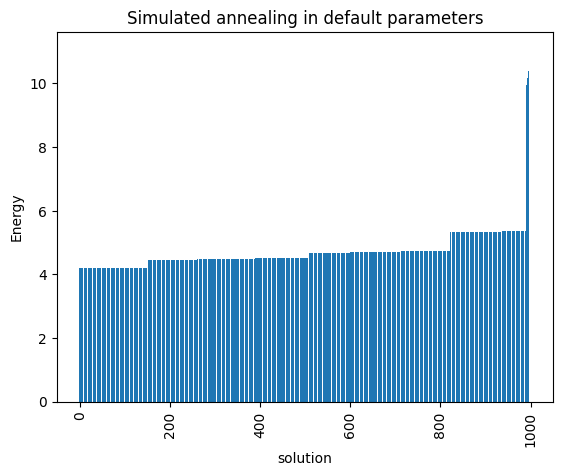

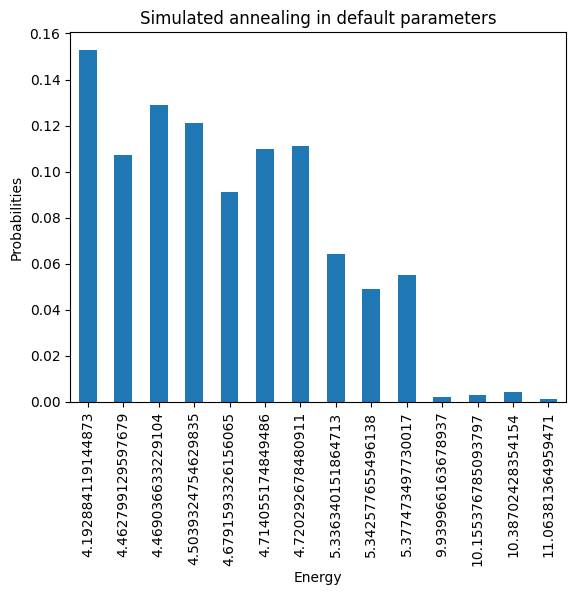

minimum energy: 4.192884119144873


{'beta_range': [0.01869221807928848, 0.8783658157104605],
 'beta_schedule_type': 'geometric',
 'timing': {'preprocessing_ns': 1948856,
  'sampling_ns': 94084311,
  'postprocessing_ns': 246685}}

In [179]:
# Simulated Annealing
mod = bqm
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(mod, num_reads=1000)
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')
simAnnSamples.info

minimum energy: 4.192884119144868


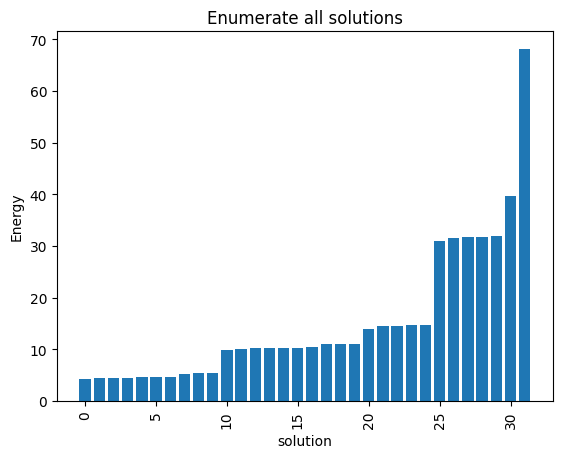

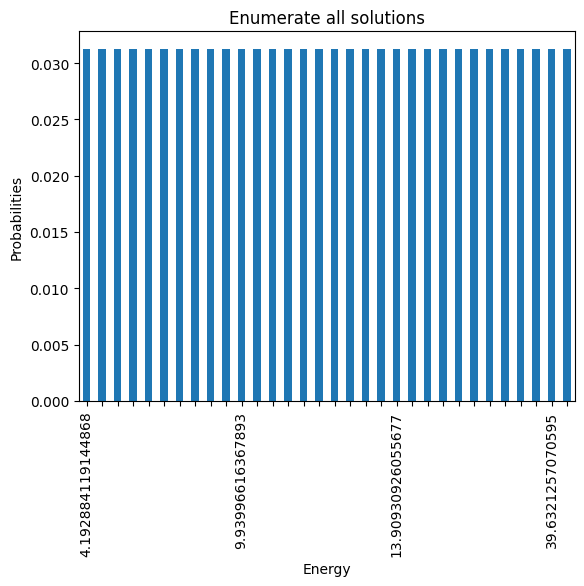

minimum energy: 4.192884119144868


In [180]:
plot_enumerate(exactSamples, title='Enumerate all solutions')
plot_energies(exactSamples, title='Enumerate all solutions', skip=10)

## Quantum Annealing via D-Wave:
This is the first interaction with D-Wave's Quantum Annealer. It will use the QUBO model introduced earlier and will define it using D-Wave's package dimod, and then solve them using neal's implementation of simulated annealing classicaly and D-Wave system package to use Quantum Annealing. We will also leverage the use of Networkx for network models/graphs.


## Time To Solution (TTS):
We would like to obtain a large probability of finding a right solution (the definition of right comes from what you define as success). On the other hand, the time it takes to solve these cases should be as small as possible. Therefore we are interested in a metric that combines both, and is called the Time To Solution (TTS) which is defined as
$$
TTS = \frac{\log{1-s}}{\log{1-p}}
$$
where s is a success factor, usually takes as $s = 99\%$, and $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within 99\% probability.
